In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")

In [159]:
def generate_moc_grid_indices_optimized(grid, dlat=2.):
    lats = np.arange(-89, 89., dlat)
    section_grid_dicts = {}
    
    # Pre-allocate section_lons once and reuse it
    section_lons = np.arange(0., 360.+5., 5.)
    
    for lat in lats: 
        if (lat % 5) == 0: 
            print(lat)
        
        # Create section_lats as numpy array directly
        section_lats = np.full_like(section_lons, lat, dtype=float)
        
        i, j, lons, lats_out = sectionate.grid_section(
            grid,
            section_lons,
            section_lats,
            topology="MOM-tripolar"
        )
        section_grid_dicts[lat] = {"i": i, "j": j, "lons": lons, "lats": lats_out}
    
    return section_grid_dicts

def transport_across_latitude_line_indices_optimized(grid, grid_indices, lat):
    i, j = grid_indices["i"], grid_indices["j"]
        
    # Calculate transport with optimized chunking
    conv_transport = sectionate.convergent_transport(grid, i, j, layer="sigma2_l", interface="sigma2_i")
    
    # Optimize the order of operations
    # First sum over "sect" then cumsum over "sigma2_l" might be faster depending on dimensions
    northward_transport = -(conv_transport['conv_mass_transport'].sum("sect")

    reverse_sigma2 = lambda ds: ds.isel({z_coord: slice(None, None, -1)})
    
    integrated_northward_transport = reverse_sigma2(reverse_sigma2(v).cumsum("sigma2_l"))
    
    # Create a singleton dimension for latitude efficiently
    lat_array = xr.DataArray([lat], dims=('lat',))
    return integrated_northward_transport.expand_dims({'lat': lat_array})
    
def global_moc_dask(grid, grid_indices):
    
    latitudes = np.sort([k for k in moc_indices.keys()])
    
    transport_tasks = []
    for lat in latitudes: 
        if (lat % 5)==0: 
            print(lat)
        transport_tasks += [transport_across_latitude_line_indices_optimized(grid, grid_indices[lat], lat)]
    
    # Combine the results
    psi = xr.concat(transport_tasks, dim="lat").sortby("lat")

    # psi_bottom_up = psi - psi.isel(sigma2_l = -1) #change convention to integrate from most dense to least dense

    # Trigger computation and return the result
    return psi_bottom_up

SyntaxError: '(' was never closed (2374075055.py, line 33)

In [81]:
from Streamfunctions import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0


In [82]:
psi = compute_streamfunction(ds, 
                       z_coord = "sigma2_l", 
                       reverse_cumsum = True)

psi = psi.compute()

In [141]:
ds_mean = ds[["umo", "vmo", "sigma2_i"]].groupby("time.year").mean("time").compute()
ds_mean = ds_mean.chunk({"year":1})
grid = CM4Xutils.ds_to_grid(ds_mean, Zprefix = "sigma2")

In [165]:
%time moc_indices = generate_moc_grid_indices(grid, dlat=1.)

-85.0
-80.0
-75.0
-70.0
-65.0
-60.0
-55.0
-50.0
-45.0
-40.0
-35.0
-30.0
-25.0
-20.0
-15.0
-10.0
-5.0
0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/sectionate/section.py:517: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.clip((np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c)), -1., 1.))


CPU times: user 3min 35s, sys: 79.7 ms, total: 3min 35s
Wall time: 3min 35s


In [166]:
ds_mean = ds[["umo", "vmo", "sigma2_i"]].groupby("time.year").mean("time").compute()
grid = CM4Xutils.ds_to_grid(ds_mean, Zprefix = "sigma2")

In [167]:

%time sectionate_psi = global_moc_dask(grid, moc_indices) * Sv_s_per_kg

-85.0
-80.0
-75.0
-70.0
-65.0
-60.0
-55.0
-50.0
-45.0
-40.0
-35.0
-30.0
-25.0
-20.0
-15.0
-10.0
-5.0
0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
CPU times: user 27.8 s, sys: 325 ms, total: 28.1 s
Wall time: 28.2 s


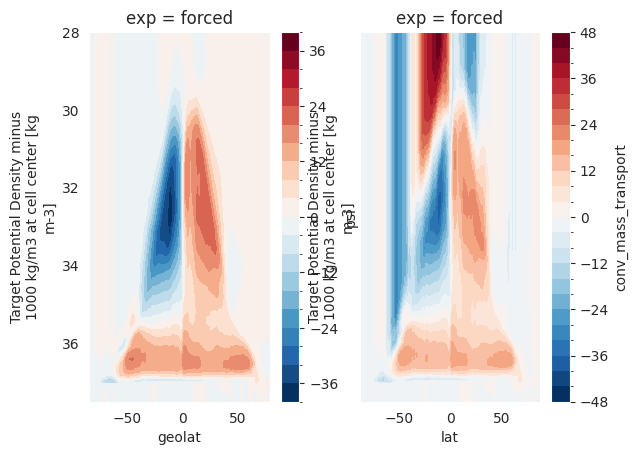

In [169]:
fig, ax = plt.subplots(1, 2, sharey = True)
levels = np.arange(-40, 41, 2)
(1e-6 * psi.mean("time")).isel(exp = 0).plot.contourf(x = "geolat", y = "sigma2_l", ax = ax[0], levels = 25)
sectionate_psi.mean('year').isel(exp = 0).plot.contourf(x = "lat", y = "sigma2_l", ax = ax[1], levels = 25)

ax[0].set_ylim(28, 37.5)
ax[0].invert_yaxis()

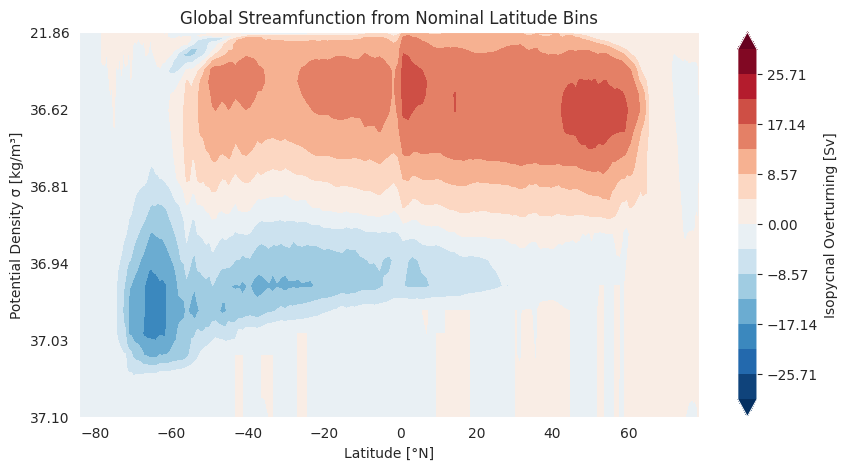

In [172]:
# If your variables have different names

psi_crop =  1e-6 * psi.mean("time").sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-30, 30, 15)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1),
    streamfunction_var='psi',  # Your streamfunction variable name
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='geolat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

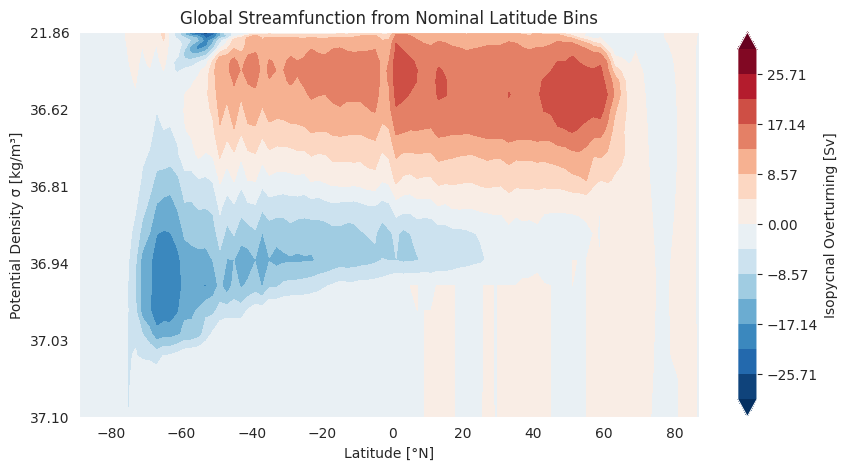

In [173]:
# If your variables have different names

psi_crop =  sectionate_psi_reorient.sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-30, 30, 15)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1).T,
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='lat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

In [174]:
psi_yearly = psi.groupby("time.year").mean("time")
psi_yearly = psi_yearly.sel(sigma2_l = slice(36, 37.1))

In [186]:
locs = find_min_locations(psi_yearly.isel(exp = 1), fixed_dim = "year")
locs["geolat"] = 0 * locs["yq"]
locs["geolat"].values = psi_yearly["geolat"].sel(yq = locs["yq"]).values
nom_locs = locs["geolat"]

Text(0.5, 1.0, 'Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)')

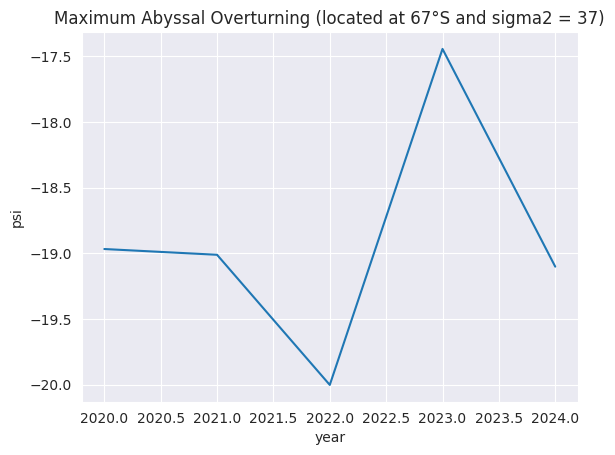

In [179]:
locs = find_min_locations(psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(1e-6 * psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)
ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")

In [188]:
locs = find_min_locations(sectionate_psi.sel(sigma2_l = slice(36, 37.1)).isel(exp = 1), fixed_dim = "year")
locs

<xarray.Dataset> Size: 148B
Dimensions:   (year: 5)
Coordinates:
    exp       <U7 28B 'control'
  * year      (year) int64 40B 2020 2021 2022 2023 2024
Data variables:
    lat       (year) float64 40B -62.0 -67.0 -64.0 -55.0 -60.0
    sigma2_l  (year) float64 40B 37.0 37.0 37.0 36.09 36.97

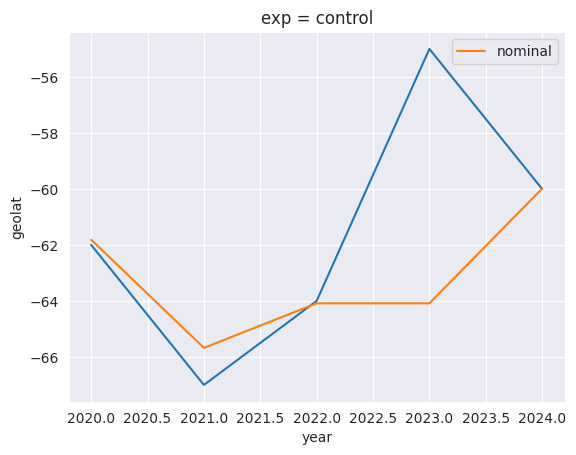

In [190]:
locs["lat"].plot()
nom_locs.plot(label = "nominal")
plt.legend()

Text(0.5, 1.0, 'Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)')

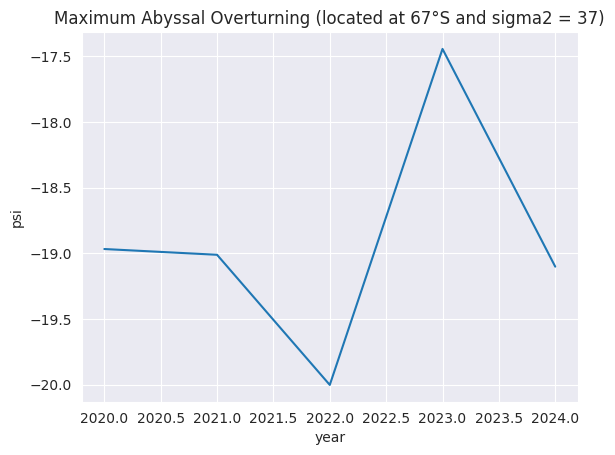

In [181]:
locs = find_min_locations(psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(1e-6 * psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)
ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")